In [1]:
import glam
import pandas as pd
import numpy as np
import os.path
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
from analysis_functions import sci_notation
from seaborn import despine

import matplotlib.pyplot as plt

/Users/felixmolter/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
np.random.seed(14) # from random.org

# SI 1 GLAM parameter recovery

## Load training data set

In [3]:
# Load data
train_data = pd.read_csv('data/krajbich_2011_pnas/data_pnas2011_preprocessed_train.csv')
train_data = train_data[['subject', 'trial', 'choice', 'rt',
             'item_value_0', 'item_value_1', 'item_value_2',
             'gaze_0', 'gaze_1', 'gaze_2']]
train_data.head()

,subject,trial,choice,rt,item_value_0,item_value_1,item_value_2,gaze_0,gaze_1,gaze_2
0,0,0,1,1782,1,7,3,0.096864,0.791638,0.111498
1,0,2,2,1171,3,1,2,0.534224,0.000000,0.465776
2,0,4,0,1476,6,1,3,0.340448,0.488794,0.170758
3,0,6,2,1482,3,1,7,0.178636,0.482944,0.338420
4,0,8,2,1393,1,2,7,0.213859,0.215054,0.571087


## Parameter recovery

### 1. Simulate data from hierarchically estimated parameters

In [4]:
print('  Simulating data set with hierarchically estimated parameters...')

# Model setup
glam_full = glam.GLAM(train_data)
glam_full.make_model('hierarchical', gamma_bounds=(-1, 1), t0_val=0)

# Load parameter estimates
glam_full.estimates = np.load('results/estimates/glam_full_hierarchical_cv.npy')[()]

# Generate model predictions
glam_full.predict(n_repeats=1)
glam_full.prediction.head()

  Simulating data set with hierarchically estimated parameters...
Generating hierarchical model for 30 subjects...


,choice,repeat,rt,subject,trial,item_value_0,gaze_0,item_value_1,gaze_1,item_value_2,gaze_2
0,1.0,0.0,920.0,0.0,0.0,1,0.096864,7,0.791638,3,0.111498
1,0.0,0.0,1269.0,0.0,1.0,3,0.534224,1,0.000000,2,0.465776
2,0.0,0.0,1852.0,0.0,2.0,6,0.340448,1,0.488794,3,0.170758
3,2.0,0.0,838.0,0.0,3.0,3,0.178636,1,0.482944,7,0.338420
4,2.0,0.0,1214.0,0.0,4.0,1,0.213859,2,0.215054,7,0.571087


### 2. Recover parameters (estimation)

In [5]:
print('  Hierarchically estimating parameters from simulated data...')

# Model setup
recovery_model = glam.GLAM(glam_full.prediction)
recovery_model.make_model('hierarchical', gamma_bounds=(-1, 1), t0_val=0)

# Fit model
recovery_model.fit(method='ADVI', n_advi=200000)

  Hierarchically estimating parameters from simulated data...
Generating hierarchical model for 30 subjects...
Fitting 1 model(s) using ADVI...
  Fitting model 1 of 1...


Average Loss = 12,619: 100%|██████████| 200000/200000 [19:05<00:00, 174.57it/s]
Finished [100%]: Average Loss = 12,619


/!\ Automatically setting parameter precision...


In [6]:
generating = glam_full.estimates
recovered = recovery_model.estimates

# Figure SI 1

In [7]:
def plot_correlation(x, y,
                     xlabel='',
                     ylabel='',
                     title='',
                     ci=0.95,
                     xticks=None,
                     yticks=None,
                     xticklabels=None,
                     yticklabels=None,
                     xlim=None,
                     ylim=None,
                     annotation_pos=(0.1, 0.1),
                     annotation_halign='left',
                     annotation_valign='bottom',
                     fontsize_title=16,
                     fontsize_axeslabel=16,
                     fontsize_ticklabels=12,
                     fontsize_annotation=12,
                     plot_diagonal=False,
                     ax=None):

    # Defaults
    if ax is None:
        fig, ax = plt.subplots()

    # Scatter
    ax.scatter(x, y, color='black', alpha=0.5)

    # LM fit
    X = sm.add_constant(x)
    lm = sm.OLS(y, X).fit()
    intercept, slope = lm.params
    table, data, columns = summary_table(lm, alpha=1.-ci)
    predicted, mean_ci_lower, mean_ci_upper = data[:, np.array([2, 4, 5])].T

    xs = np.linspace(*ax.get_xlim(), 100)
    ax.plot(xs, intercept + slope * xs,
            color='r')
    sort_idx = np.argsort(x)
    ax.fill_between(x[sort_idx], mean_ci_lower[sort_idx], mean_ci_upper[sort_idx],
                    color='red', alpha=0.1)
    
    # Annotation
    tval = lm.tvalues[-1]
    pval = lm.pvalues[-1]
    r = np.sign(tval) * np.sqrt(lm.rsquared)
    ax.text(*annotation_pos,
            (r'$r = {:.2f}$, '.format(r)) +
             r'$P =${}'.format(sci_notation(pval, exact=True, decimal_digits=2)),
            verticalalignment=annotation_valign,
            horizontalalignment=annotation_halign,
            transform=ax.transAxes,
            fontsize=fontsize_annotation,
            bbox=dict(facecolor='white', alpha=0.75))

    # Axes, ticks, ...
    if xticks is not None:
        ax.set_xticks(xticks)
    if yticks is not None:
        ax.set_yticks(yticks)
        
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels, fontsize=fontsize_ticklabels)
    if yticklabels is not None:
        ax.set_yticklabels(yticklabels, fontsize=fontsize_ticklabels)

    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    # Diagonal
    if plot_diagonal:
        ax.plot([0, 1], [0, 1], transform=ax.transAxes,
                color='black', alpha=0.5, zorder=-10, lw=1)

    # Labels
    ax.set_xlabel(xlabel, fontsize=fontsize_axeslabel)
    ax.set_ylabel(ylabel, fontsize=fontsize_axeslabel)
    ax.set_title(title, fontsize=fontsize_title)
    despine()

    return ax

In [8]:
def blank_second(x, offset=0):
    out = []
    for i, xx in enumerate(x):
        if (i + offset) % 2 == 0:
            out.append(xx)
        else:
            out.append('')
    return out

In [9]:
def figure_si1(generating, recovered,
               parameters=['v', 'gamma', 's', 'tau'],
               parameter_labels=dict(v='v',
                                     s=r'$\sigma$',
                                     gamma=r'$\gamma$',
                                     tau=r'$\tau$'),
               parameter_ticks=dict(v=np.arange(0, 0.00021, 0.00005),
                                    s=np.arange(0.004, 0.0151, 0.002),
                                    gamma=np.arange(-1, 1.1, 0.25),
                                    tau=np.arange(0.0, 1.6, 0.5)),
               parameter_ticklabels=dict(v=blank_second(np.arange(0, 0.00021, 0.00005)),
                                         s=blank_second(np.arange(0.004, 0.0151, 0.002), offset=1),
                                         gamma=blank_second(np.arange(-1, 1.1, 0.25)),
                                         tau=np.arange(0, 1.6, 0.5)),
               figsize=(16, 3.5)):

    n_parameters = len(parameters)

    fig, axs = plt.subplots(1, n_parameters, figsize=figsize)

    for i, p in enumerate(parameters):

        plot_correlation(generating[p], recovered[p],
                         xlabel='Generating',
                         ylabel='Recovered',
                         title=parameter_labels[p],
                         ci=0.95,
                         xticks=parameter_ticks[p],
                         yticks=parameter_ticks[p],
                         xticklabels=parameter_ticklabels[p],
                         yticklabels=parameter_ticklabels[p],
                         xlim=(parameter_ticks[p][0], parameter_ticks[p][-1]),
                         ylim=(parameter_ticks[p][0], parameter_ticks[p][-1]),
                         annotation_pos=(0.05, 0.95),
                         annotation_halign='left',
                         annotation_valign='top',
                         fontsize_title=16,
                         fontsize_axeslabel=16,
                         fontsize_ticklabels=12,
                         fontsize_annotation=11,
                         plot_diagonal=True,
                         ax=axs[i])

    # index axes
    for label, ax in zip(list('ABCDE'), axs.ravel()):
        ax.text(-0.1, 1.15, label, transform=ax.transAxes,
                fontsize=16, fontweight='bold', va='top')
        
    fig.tight_layout()
    despine()

    return fig, axs

Close figure to continue...


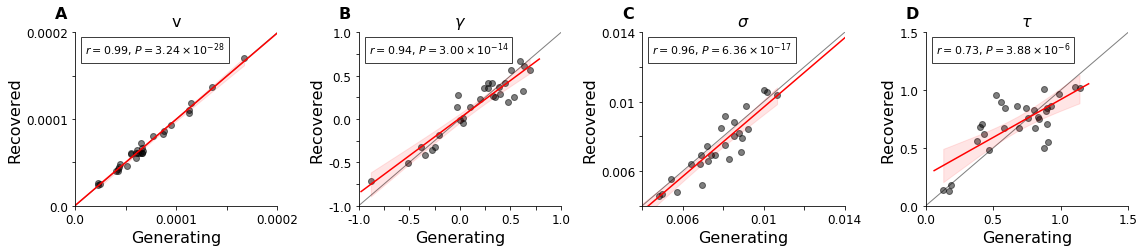

In [10]:
print('Close figure to continue...')
figure_si1(generating, recovered, parameters=['v', 'gamma', 's', 'tau'])
plt.savefig('results/figures/figure_si1_parameter_recovery.png', dpi=330, bbox_inches='tight')
plt.show()